# HMM

The key here is to fasten the process. Clustering algorihm such as EM takes a lot of time and memory. One may think, how can I help the computer proceed easier?

The first idea is to reduce the number of points. Less points means less data to work with:
- 1st method would be to shuffle all the dataset and get a certain percentage of it. 
- 2nd method idea would be to randomly select a point, calculate its neighbors and sort them. Then do a random walk in the nearest points. This permits to retain a certain pattern from the original dataset


The second idea is to represent the dataset as a graph. Each point would be a graph's node. Those nodes have for edges their neighboordhood.This means that:
- node 1 would connect to 2 and 3, 
- node 2 would connect to 1 and 3,
- node 3 would connect to 2 and 4

This will provide different degrees to each node. Intuitively, we can imagine that the nodes with the biggest number of degrees are the most meaningfull in the dataset. Then, we could use these meaningfull nodes as a prior for our clustering and therefore fasten the process.

One could also say that mixing both approach could be interesting: reduce the number of points before representing graphically our dataset

In [198]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation
import igraph
#from igraph import plot
from sklearn.cluster import KMeans
import time
import numpy.random as rd
import scipy.stats as ss

In [199]:
!pip install python-igraph

Let's use the following paramaters to initiate our mulmtivariate gaussian:

In [200]:
#Parameters
N=1000
K=3
true_pi= np.array([0.3,0.3,0.4])
true_mu=np.array([[0,0],[1,2],[2,0]])
#true_mu=np.array([[-3,2],[0,-2],[2,2]])
true_sigma= np.array([[[1.00, -0.25], [-0.25, 0.50]],[[0.50, 0.25],[0.25, 0.50]],[[0.50, -0.25],[ -0.25, 1]]])

In [201]:
true_sigma

array([[[ 1.  , -0.25],
        [-0.25,  0.5 ]],

       [[ 0.5 ,  0.25],
        [ 0.25,  0.5 ]],

       [[ 0.5 , -0.25],
        [-0.25,  1.  ]]])

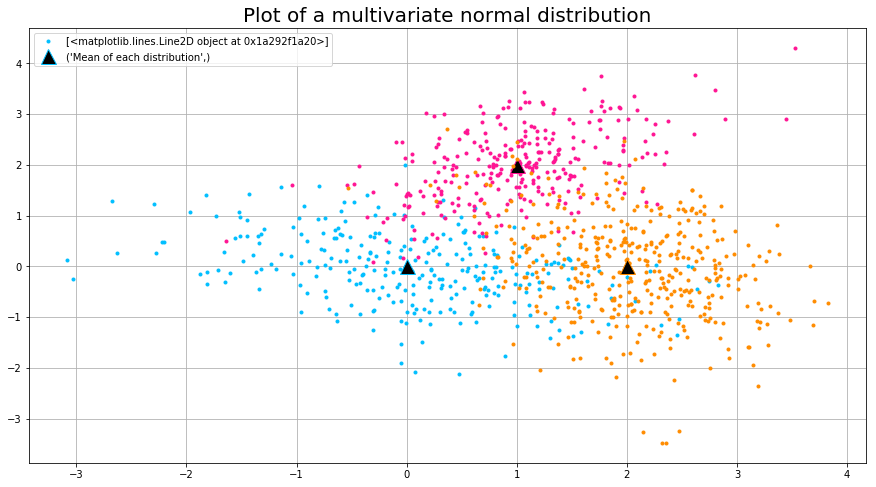

In [202]:
#Nb of values -n- in each distributions
list_N=np.random.multinomial(N, true_pi)

#list_x is a list of lists containing each distributions
list_x=[]
for i in range(K):
    list_x.append(np.random.multivariate_normal(true_mu[i], true_sigma[i], list_N[i]))
    
#X is the jointure of all the lists in x_list in one list 
X=np.vstack(list_x)

#First simple plot to see data
plt.figure(figsize=(15,8))
plt.grid()
color_list=["deepskyblue","deeppink","darkorange","forestgreen","blueviolet"] #funky color, because we like it

for i in range(K):
    x_plot = plt.plot(list_x[i][:,0],list_x[i][:,1],'.',color=color_list[i],label="Gaussienne n°%d"%i)
    mean_plot = plt.plot(true_mu[i,0],true_mu[i,1],'^k',markersize=15,mec = color_list[i])
    
plt.legend([(mean_plot),("Mean of each distribution",)])
plt.title("Plot of a multivariate normal distribution", fontsize="20")
plt.show()

In [203]:
def n_idx_random_neighboor_walk(node,nodes,n):
    dist_2 = np.sum((nodes - node)**2, axis=1)
    path = np.random.choice(np.argsort(dist_2)[:n])
    return path
    

In [204]:
#RANDOM WALK WITH NEIGHBOORS
size_path=10
neighboord_hood_size = 10
paths=[]
nb_iteration = 30

for i in range(nb_iteration):
    path=[]
    for j in range(size_path):
        x_init = np.random.choice(np.max(N-neighboord_hood_size,0),1)
        path.append(n_idx_random_neighboor_walk(X[x_init],X,neighboord_hood_size))
    paths.append(path)

l_idx_nodes_rw=list(np.array(paths).flatten()) # all the paths are already added here in a long flatted list
l=[str(el) for el in np.array(paths).flatten()]



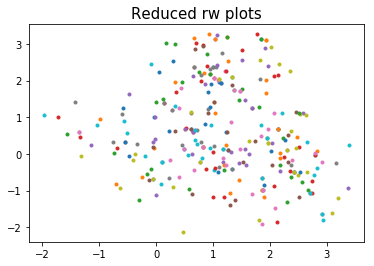

In [205]:
#plt.plot(X[l_idx_nodes_rw][:,0],X[l_idx_nodes_rw][:,1],'.')

for i in range(np.shape(paths)[0]):
    plt.plot(X[paths[i]][:,0],X[paths[i]][:,1],'.')
plt.title("Reduced rw plots", fontsize=15)
plt.show()

Now let's get to the seconde idea: graphs

In [214]:
def n_idx_closest_points(node,nodes,n):
    dist_2 = np.sum((nodes - node)**2, axis=1)
    l_idx_nodes = np.argsort(dist_2)[:n]
    #print(np.max(dist_2))
    return l_idx_nodes

def n_idx_closest_points_1(node,nodes):
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argwhere(dist_2 < np.quantile(dist_2[:2],q=0.01)).flatten()


def pairs_for_edges(l_idx_nodes):
    l=[]
    for i in range(len(l_idx_nodes)):
        sublist=[]
        for j in range(1,len(l_idx_nodes[i])):
            sublist.append([l_idx_nodes[i][0],l_idx_nodes[i][j]])
        l.append(sublist)
    return l

def pairs_flatter(pairs_for_edges):
    return [el for sublist in pairs_for_edges for el in sublist]

In [215]:
l_idx_nodes=[]
#Calcul des n nodes les plus pres de chacun des nodes
def f_l_idx_nodes(X):
    for i in range(len(X)):
        #l_idx_nodes.append(n_idx_closest_points(X[i],X,5))
        l_idx_nodes.append(n_idx_closest_points_1(X[i],X))
    return l_idx_nodes

l_idx_nodes=f_l_idx_nodes(X[l_idx_nodes_rw])
#l_idx_nodes=f_l_idx_nodes(X)

In [216]:
l_idx_nodes[4].shape

(12,)

In [217]:
#g = igraph.Graph(directed=True)
g = igraph.Graph()


In [218]:
g.add_vertices(N)
g.add_edges(pairs_flatter(pairs_for_edges(l_idx_nodes)))
g= g.simplify()


In [225]:
#igraph.plot(g)#.save("lol1.png")

In [237]:
k_core = np.argsort(g.degree(loops= False))[::-1][:3]
#k_core = np.argsort(g.coreness())[::-1][:3]

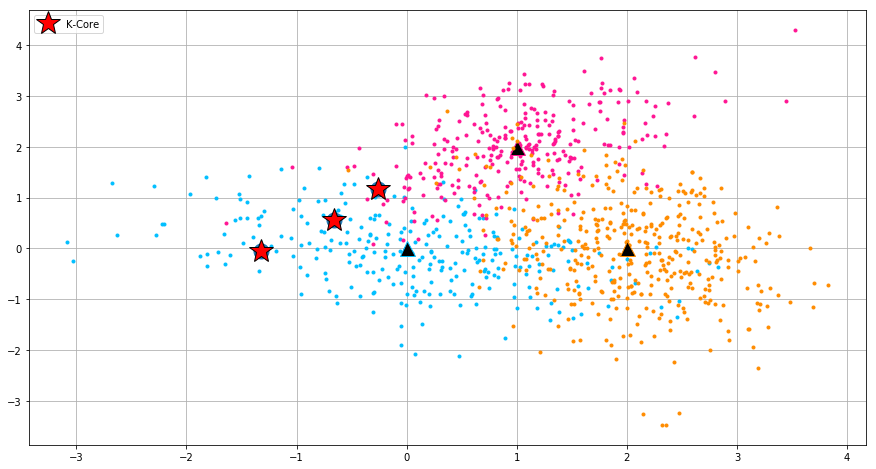

In [238]:
plt.figure(figsize=(15,8))
plt.grid()
color_list=["deepskyblue","deeppink","darkorange","forestgreen","blueviolet"] #funky color, because we like it

for i in range(K):
    x_plot = plt.plot(list_x[i][:,0],list_x[i][:,1],'.',color=color_list[i])#,label="Gaussienne n°%d"%i)
    mean_plot = plt.plot(true_mu[i,0],true_mu[i,1],'^k',markersize=15,mec = color_list[i])
    
plt.plot(X[k_core][:,0],X[k_core][:,1], 'o', markersize=15 )
kmeans = KMeans(n_clusters=3).fit(X[k_core])
plt.plot(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],'*',markersize=25 ,color="red", mec="black",label = "K-Core")
plt.legend()
plt.show()

In [226]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import chi2
from matplotlib.patches import Ellipse
from matplotlib.animation import FuncAnimation

In [227]:
# All plot functions are included here
def plot_ellipses(A, mu,col):
    N = 36
    th = np.arange(0, 2 * np.pi + np.pi / N, np.pi / N)
    X = np.array([np.cos(th), np.sin(th)])
    
    Y = np.dot(A, X)
    ln = plt.Line2D(mu[0] + Y[0,:], mu[1] + Y[1,:], c=col, linewidth=2)
    return ln

def plot(x,mu, sigma, true=False):
    plt.figure(figsize=(15,8))
    plt.rc('text', usetex=False)
    if true:
        plt.title("Contours of the true Gaussians")
    else:
        plt.title("Contours of the estimated Gaussians")
    plt.grid()
    ax=plt.gca()

    for i in range(K):
        A = np.linalg.cholesky(sigma[i])
        x_plot = plt.plot(x[i][:,0],x[i][:,1],'.',color=color_list[i],label="Gaussienne n°%d"%i)
        mean_plot = plt.plot(mu[i][0],mu[i][1],'^k',markersize=15)
        ax.add_line(plot_ellipses(A,mu[i],"k"))

def plot_comparison(x,true_mu,true_sigma,mu,sigma):
    plt.figure(figsize=(15,8))
    plt.title("Contours of the estimated vs true Gaussians")
    plt.grid()
    ax=plt.gca()

    for i in range(K):
        true_A = np.linalg.cholesky(true_sigma[i])
        estimated_A = np.linalg.cholesky(sigma[i])
        x_plot = plt.plot(x[i][:,0],x[i][:,1],'.',color=color_list[i])
        true_mean_plot = plt.plot(true_mu[i][0],true_mu[i][1],'^k',mec="g",mfc=color_list[i], markersize=20)
        estimated_mean_plot = plt.plot(mu[i][0],mu[i][1],'^',mec=color_list[i],mfc='black',markersize=15)
        ax.add_line(plot_ellipses(true_A,true_mu[i],color_list[i]))
        ax.add_line(plot_ellipses(estimated_A,mu[i],'k'))
    plt.legend()
    plt.show()


def log_sum_exp(v, axis=0):
    v_max = np.max(v)
    return v_max + np.log(np.sum(np.exp(v - v_max)))

def log_det(A):
    diag = np.diag(np.linalg.cholesky(A))
    return 2 * np.sum(np.log(diag))

def comp_li(pi_i,x,mu_i,sigma_i):
    d=len(mu_i)
    li= np.log(pi_i) - d *np.log(2 *np.pi) /2 - log_det(sigma_i)/2 - (x-mu_i).T@np.linalg.inv(sigma_i)@(x-mu_i)/2
    return li
        
def comp_gamma_i(pi,x,mu,sigma,i):
    K = len(pi)
    v = np.zeros(K)

    for k in range(K):
        v[k] = comp_li(pi[k],x, mu[k], sigma[k])
    return np.exp(v[i] - log_sum_exp(v))

#ALGORITHM EM 
def log_likelihood(x,gamma, pi, mu, sigma):
    log_like = 0
    for n in range(N):
        for k in range(K):
            log_like += gamma[n,k] * comp_li(pi[k],x[n], mu[k], sigma[k])
    return log_like

def EM(x,number_iteration, pi, mu, sigma, likelihood=False):
    gamma = np.zeros((N, K))
    t0 = time.time()
    time_array=[]
    likelihood_array = []
    plot_each=number_iteration//3
    for i in range(number_iteration):
        if i%plot_each==0:
            plot(list_x,mu,sigma)
        # E step 
        for n in range(N):
            for k in range(K):
                gamma[n,k] = comp_gamma_i(pi,x[n],mu,sigma,k)
                
        # Likelihood
        if likelihood:
            likelihood_array.append(log_likelihood(x,gamma, pi, mu, sigma))
            time_array.append(time.time() - t0)
            
        # M step 
        for k in range(K):
            mu[k] = np.zeros(len(mu[0]))
            for n in range(N):
                mu[k] += gamma[n,k] * x[n]
            mu[k] /= np.sum(gamma[:,k])
        sigma = np.zeros((3, 2, 2))
        for k in range(K):
            for n in range(N):
                A = np.reshape(x[n] - mu[k], (2,1))
                sigma[k] += gamma[n,k] * np.dot(A, A.T)
            sigma[k] /= np.sum(gamma[:,k])
            
        # PI
        for k in range(K):
            pi[k] = np.average(gamma[:,k])

        
    return pi, mu, sigma, likelihood_array,time_array

In [228]:
pi = np.random.rand(K)
pi = pi / np.sum(pi)

mu = []
sigma = []
for i in range(K):
    mu.append(np.random.randint(-1,5,2)) # for instance 
    A = np.array([[1,0],[0,1]]) #np.random.rand(2,2)
    sigma.append(list(A.dot(A.T)))
#mu = kmeans.cluster_centers_  


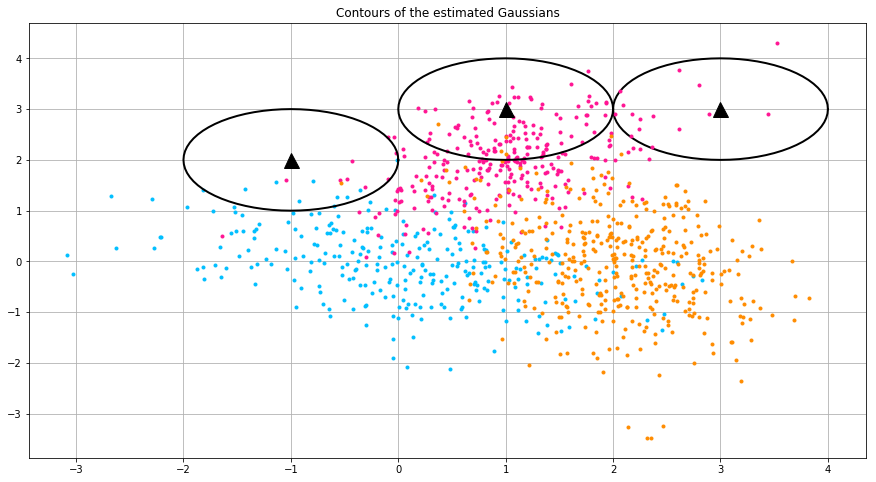

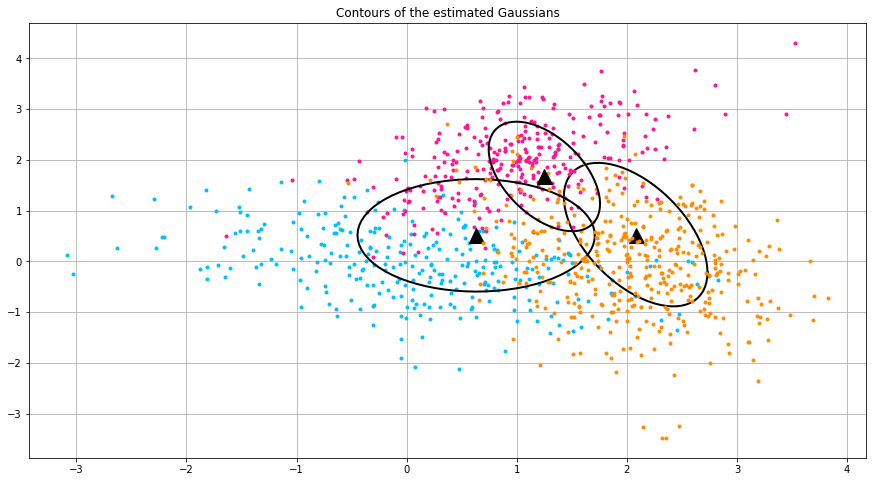

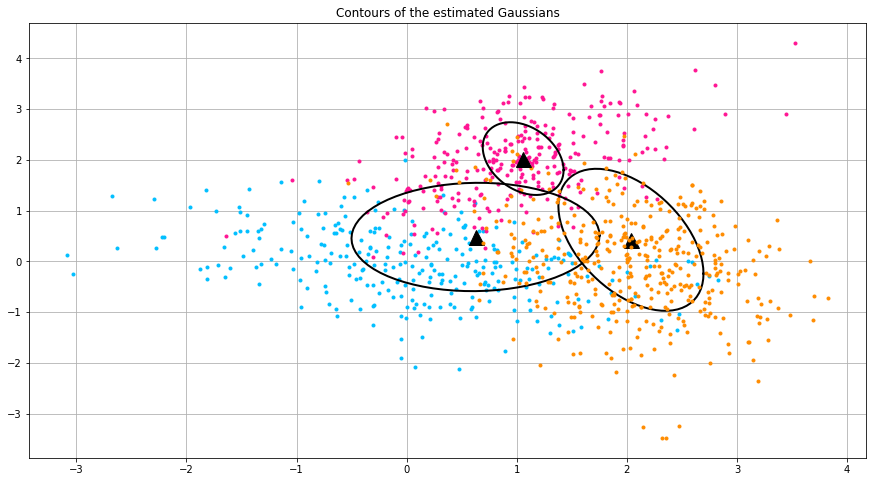

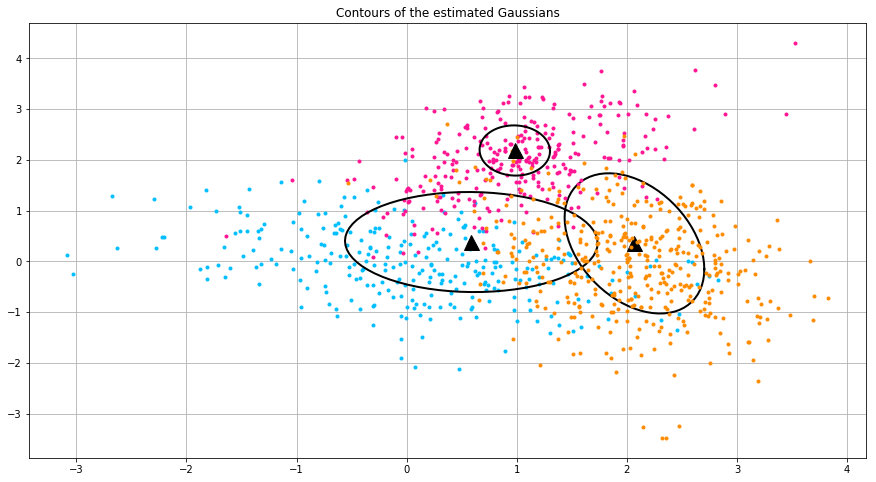

In [229]:
pi, mu, sigma, likelihood_array, time_array = EM(X,10, pi, mu, sigma,likelihood=True)

In [230]:
pi_init = np.random.rand(K)
pi_init = pi_init / np.sum(pi_init)

mu_init = []
sigma_init = []
for i in range(K):
    A = np.array([[1,0],[0,1]]) #np.random.rand(2,2)
    sigma_init.append(list(A.dot(A.T)))
mu_init = kmeans.cluster_centers_  
gamma_init = np.zeros((N, K))

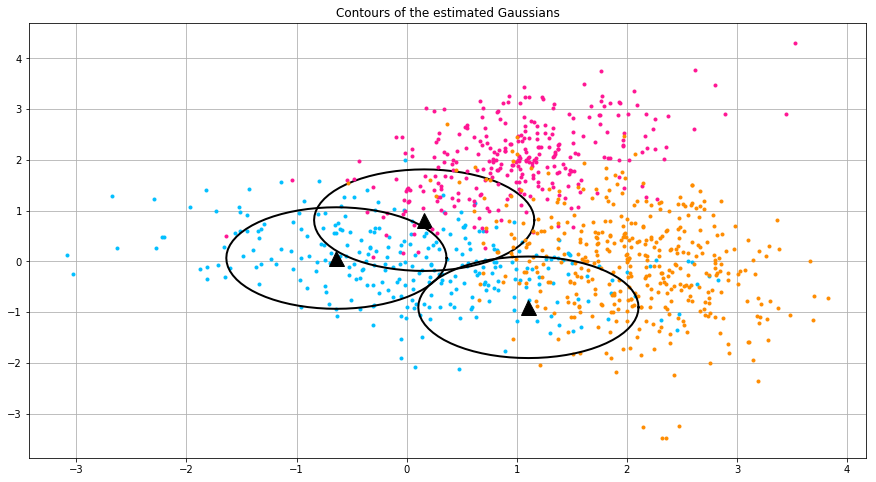

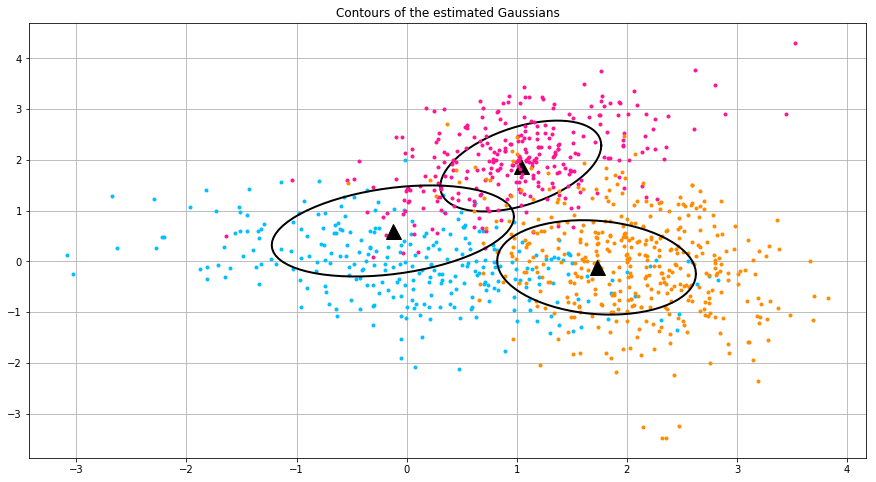

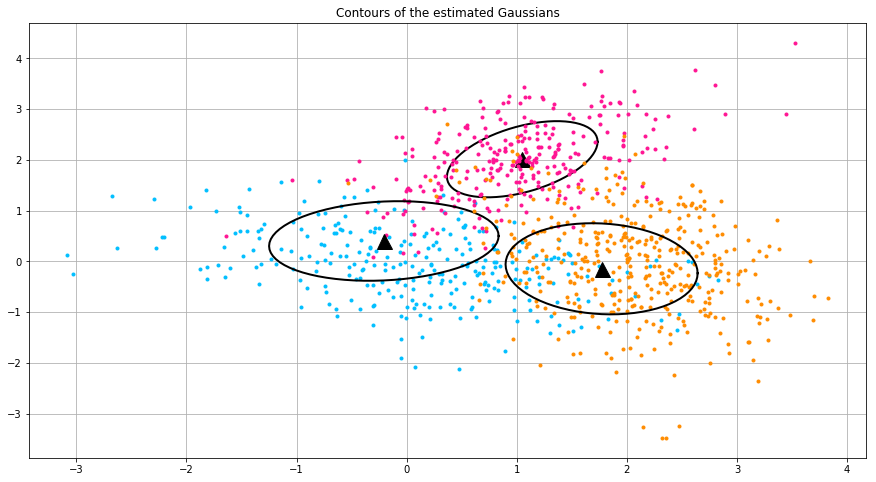

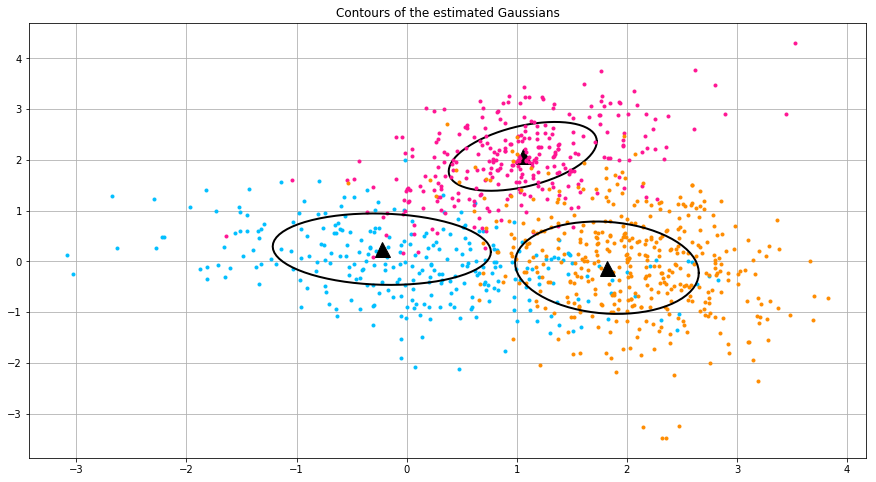

In [231]:
pi_init, mu_init, sigma_init, likelihood_array_init, time_array_init = EM(X,10, pi_init, mu_init, sigma_init
                                                                     ,likelihood=True)

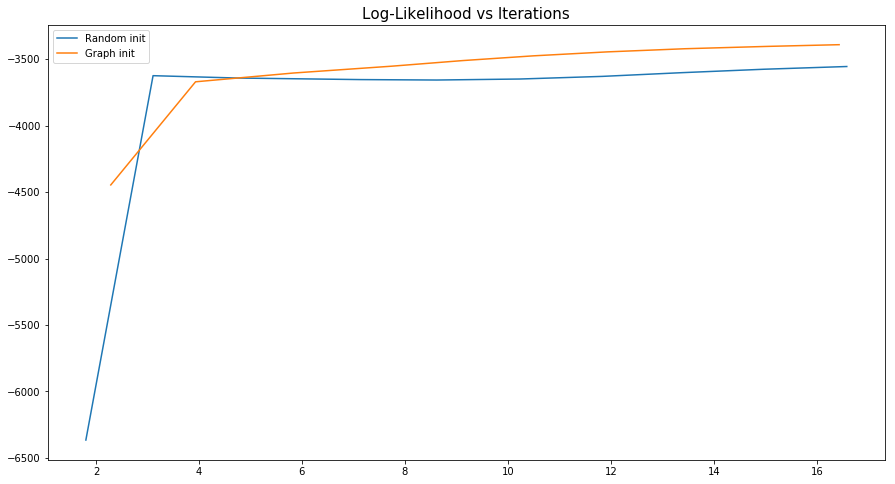

In [232]:
plt.figure(figsize=(15,8))
plt.title("Log-Likelihood vs Iterations", fontsize=15)
plt.plot(time_array,likelihood_array, label="Random init")
plt.plot(time_array_init,likelihood_array_init, label="Graph init")
plt.legend()
plt.show()

In [24]:
KMeans(3).fit(X).cluster_centers_

array([[ 1.96662943,  1.95785906],
       [-0.02276816, -1.99315603],
       [-3.04259503,  2.01400523]])

In [25]:
def n_idx_closest_points_1(node,nodes):
    dist_2 = np.sum((nodes - node)**2, axis=1)
    return np.argwhere(dist_2 < np.quantile(dist_2,q=0.01)).flatten()

def pairs_for_edges(l_idx_nodes):
    l=[]
    for i in range(len(l_idx_nodes)):
        sublist=[]
        for j in range(1,len(l_idx_nodes[0])):
            sublist.append([l_idx_nodes[i][0],l_idx_nodes[i][j]])
        l.append(sublist)
    return l

def pairs_flatter(pairs_for_edges):
    return [el for sublist in pairs_for_edges for el in sublist]

#Calcul des n nodes les plus pres de chacun des nodes
def f_l_idx_nodes(X):
    l_idx_nodes=[]
    for i in range(len(X)):
        #l_idx_nodes.append(n_idx_closest_points(X[i],X,5))
        l_idx_nodes.append(n_idx_closest_points_1(X[i],X))
    return l_idx_nodes
l_idx_nodes=f_l_idx_nodes(X)

g = igraph.Graph()
g.add_vertices(N)
g.add_edges(pairs_flatter(pairs_for_edges(l_idx_nodes)))
g= g.simplify()
#igraph.plot(g)
k_core = np.argsort(g.degree(loops= False))[::-1][:10]
kmeans = KMeans(n_clusters=3).fit(X[k_core])
kmeans.cluster_centers_

array([[-2.41643163,  1.5302335 ],
       [ 2.07873992,  1.63421575],
       [-0.21380847, -1.12409647]])

In [26]:
print("lol")

lol
